<a href="https://colab.research.google.com/github/GoetheUniCV/cvproject/blob/main/models/benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model



##1. Setup
###1.1 Python Environment
Almost all required packages are preinstalled, except _kerastuner_. You can install it with `!pip install -U keras-tuner`.

###1.2 Google Drive
####1.2.1 Structure
Create the following directory structure in your Drive:
```
MyDrive
└── cvproject
    ├── COVID-10 Radiography Database
    │   ├── COVID-19
    │   ├── NORMAL
    │   └── Viral Pneumonia
    └── models
```
####1.2.2 Upload COVID-19 Dataset
The directory _COVID-10 Radiography Database_ must contain the dataset from Kaggle (https://www.kaggle.com/tawsifurrahman/covid19-radiography-database).

___


In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 7.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=d51b28a0b702d8f98d942f2dabf31fdd24451dcbae43f2632af928727e17f122
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7e4bd83dbe8dc7dac6e67195dc3d8b350f8aab54e4856333e091704eb1243159
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras.preprocessing import image
from google.colab import drive
import matplotlib.cm as cm

In [3]:
# This mounts your Google Drive to the Colab VM.
drive.mount('/content/drive', force_remount=True)

# Foldername in your Drive where you have saved the COVID-19 data.
PROJECT_PATH = '/content/drive/My Drive/cvproject/'
DATABASE_PATH = f'{PROJECT_PATH}/COVID-19 Radiography Database'
MODELS_PATH = f'{PROJECT_PATH}/models'

#assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
#sys.path.append(FOLDERPATH)

Mounted at /content/drive


In [4]:
# Check if database is complete.
try:
  if len(os.listdir(f'{DATABASE_PATH}/COVID-19')) == 1143:
    print('COVID-19 complete.')
  else:
    print('COVID-19 incomplete.')

  if len(os.listdir(f'{DATABASE_PATH}/NORMAL')) == 1341:
    print('NORMAL complete.')
  else:
    print('NORMAL incomplete.')

  if len(os.listdir(f'{DATABASE_PATH}/Viral Pneumonia')) == 1345:
    print('Viral Pneumonia complete.')
  else:
    print('Viral Pneumonia incomplete.')
except FileNotFoundError:
  print("Warning: Some directories are missing!")



COVID-19 complete.
NORMAL complete.
Viral Pneumonia complete.


In [5]:
# Show label name and its encoded value:
class_names =  ["COVID-19","NORMAL","Viral Pneumonia"]

for i, class_name in enumerate(class_names):
    print(f'{class_name}: {i}')

COVID-19: 0
NORMAL: 1
Viral Pneumonia: 2


In [6]:
# NOTE: Bildgröße aller Bilder wird auf 244 x 244 geändert. Leider sind die
#       Covid Bilder sehr klein. Normale und Lungenentzündung sind 1024 x 1024.

# NOTE: removed '= defect_tree ='

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 3829 files belonging to 3 classes.
Using 3064 files for training.
Found 3829 files belonging to 3 classes.
Using 765 files for validation.


In [7]:
# Defining the CNNs.
model_1 = tf.keras.models.Sequential([
  layers.Conv2D(64, 5, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_2 = tf.keras.models.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

models = [model_1, model_2]

In [8]:
# Avoid overfitting...
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [9]:
# Compile the models.
for model in models:  
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Fit the model.
histories = []
for model in models:
  histories.append(model.fit(train_data,validation_data= test_data,batch_size=32,epochs = 20,callbacks=[early]))  

Epoch 1/20
96/96 [==============================] - 985s 10s/step - loss: 5870.7531 - accuracy: 0.5950 - val_loss: 1.8672 - val_accuracy: 0.8431
Epoch 2/20
96/96 [==============================] - 54s 536ms/step - loss: 0.6809 - accuracy: 0.9001 - val_loss: 1.9571 - val_accuracy: 0.8745
Epoch 3/20
96/96 [==============================] - 54s 533ms/step - loss: 0.3167 - accuracy: 0.9568 - val_loss: 1.8414 - val_accuracy: 0.8784
Epoch 4/20
96/96 [==============================] - 54s 535ms/step - loss: 0.1010 - accuracy: 0.9768 - val_loss: 1.8811 - val_accuracy: 0.8706
Epoch 5/20
96/96 [==============================] - 54s 535ms/step - loss: 0.1024 - accuracy: 0.9815 - val_loss: 1.9524 - val_accuracy: 0.8824
Epoch 6/20
96/96 [==============================] - 54s 536ms/step - loss: 0.0661 - accuracy: 0.9800 - val_loss: 2.2239 - val_accuracy: 0.8824
Epoch 7/20
96/96 [==============================] - 55s 539ms/step - loss: 0.0818 - accuracy: 0.9858 - val_loss: 2.3311 - val_accuracy: 0.87

In [11]:
# Evaluate the model.
for i, model in enumerate(models):
  print(f'Evaluation of model {i}:')
  model.evaluate(test_data)

Evaluation of model 0:
24/24 [==============================] - 10s 279ms/step - loss: 2.2525 - accuracy: 0.8601
Evaluation of model 1:
24/24 [==============================] - 10s 280ms/step - loss: 4.6364 - accuracy: 0.9268


Model 0:


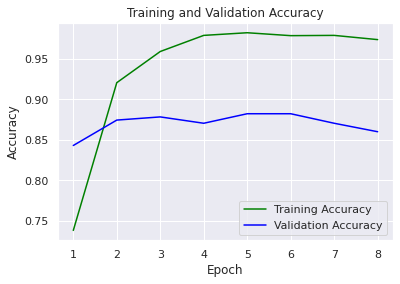

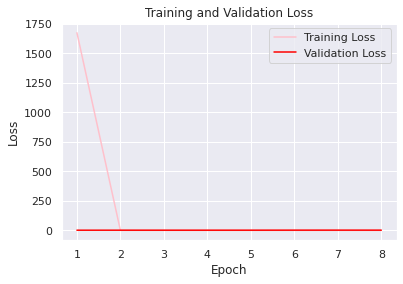

____________________________
Model 1:


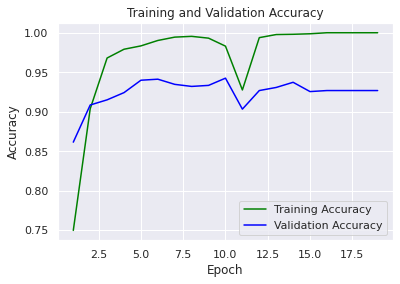

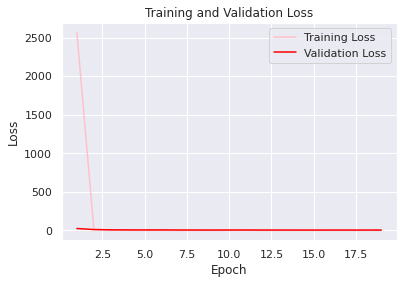

____________________________


In [13]:
for i, history in enumerate(histories):
  print(f'Model {i}:')
  #plotting training values
  sns.set()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  #accuracy plot
  plt.plot(epochs, acc, color='green', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()

  plt.figure()
  #loss plot
  plt.plot(epochs, loss, color='pink', label='Training Loss')
  plt.plot(epochs, val_loss, color='red', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()
  print('____________________________')

Model 0:


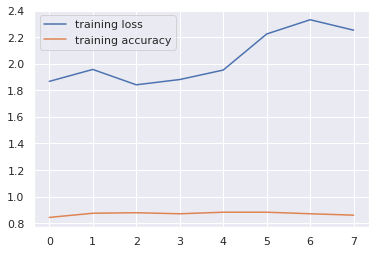

Model 1:


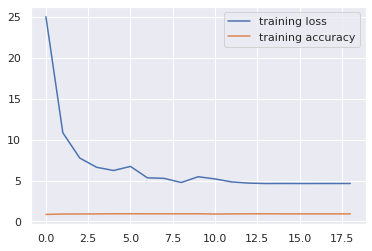

In [18]:
for i, history in enumerate(histories):
  print(f'Model {i}:')
  #train data accuracy and loss
  plt.plot(history.history['val_loss'], label = 'training loss')
  plt.plot(history.history['val_accuracy'], label = 'training accuracy')
  plt.legend()
  plt.show()


Model 0:


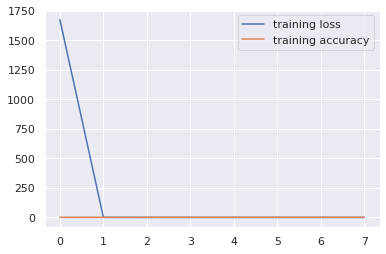

Model 1:


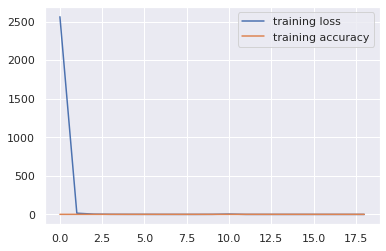

In [20]:
for i, history in enumerate(histories):
  print(f'Model {i}:')
  #test data accuracy and loss
  plt.plot(history.history['loss'], label = 'training loss')
  plt.plot(history.history['accuracy'], label = 'training accuracy')
  plt.legend()
  plt.show()

In [22]:
#save models as .h5 file

for i, model in enumerate(models):
  model_json = model.to_json()
  with open(f"model_{i}.json", "w") as json_file:
    json_file.write(model_json)
  # serialize weights to HDF5
  model.save(f'{MODELS_PATH}/model_{i}.h5')

In [23]:
 for model in models:
  print(f'Model {i}:')
  model.summary()
  print('_______________________________________')

Model 1:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 921600)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               235929856 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 235,935,491
Trainable params: 235,935,491
Non-trainable params: 0
_________________________________________________________________
_______________________________________
Model 1:
Model: "sequential_1"
____________________________